# CLAUDE SONNETv4.5

All libraries imported successfully!
Enter city/state/nation name: lucknow, uttar pradesh, india
✓ Location verified: Lucknow, Uttar Pradesh, 226027, India
  Coordinates: (26.8381, 80.9346001)

✓ Boundary downloaded: 1 feature(s)
✓ Sports infrastructure downloaded: 135 feature(s)

Converting to EPSG:32643 (WGS 84 / UTM zone 43N)...
✓ Boundary converted to EPSG:32643
✓ Sports infrastructure converted to EPSG:32643

Rasterizing sports infrastructure...
✓ Raster grid created: 1444x1340 pixels at 50m resolution

Building sports infrastructure heatmap with influence zones...
Processing 135 sports facilities...
Maximum influence distance: 4.0km
  Processed 50/135 facilities...
  Processed 100/135 facilities...
  Processed 135/135 facilities...
✓ Heatmap created with overlapping 4.0km influence zones
  Heatmap range: 0.000 to 16.084
  Maximum overlaps: 16.1 facilities

Importing GHSL population data...
✓ GHSL population data loaded
✓ Population data downloaded: (730, 732)
✓ Population resampl

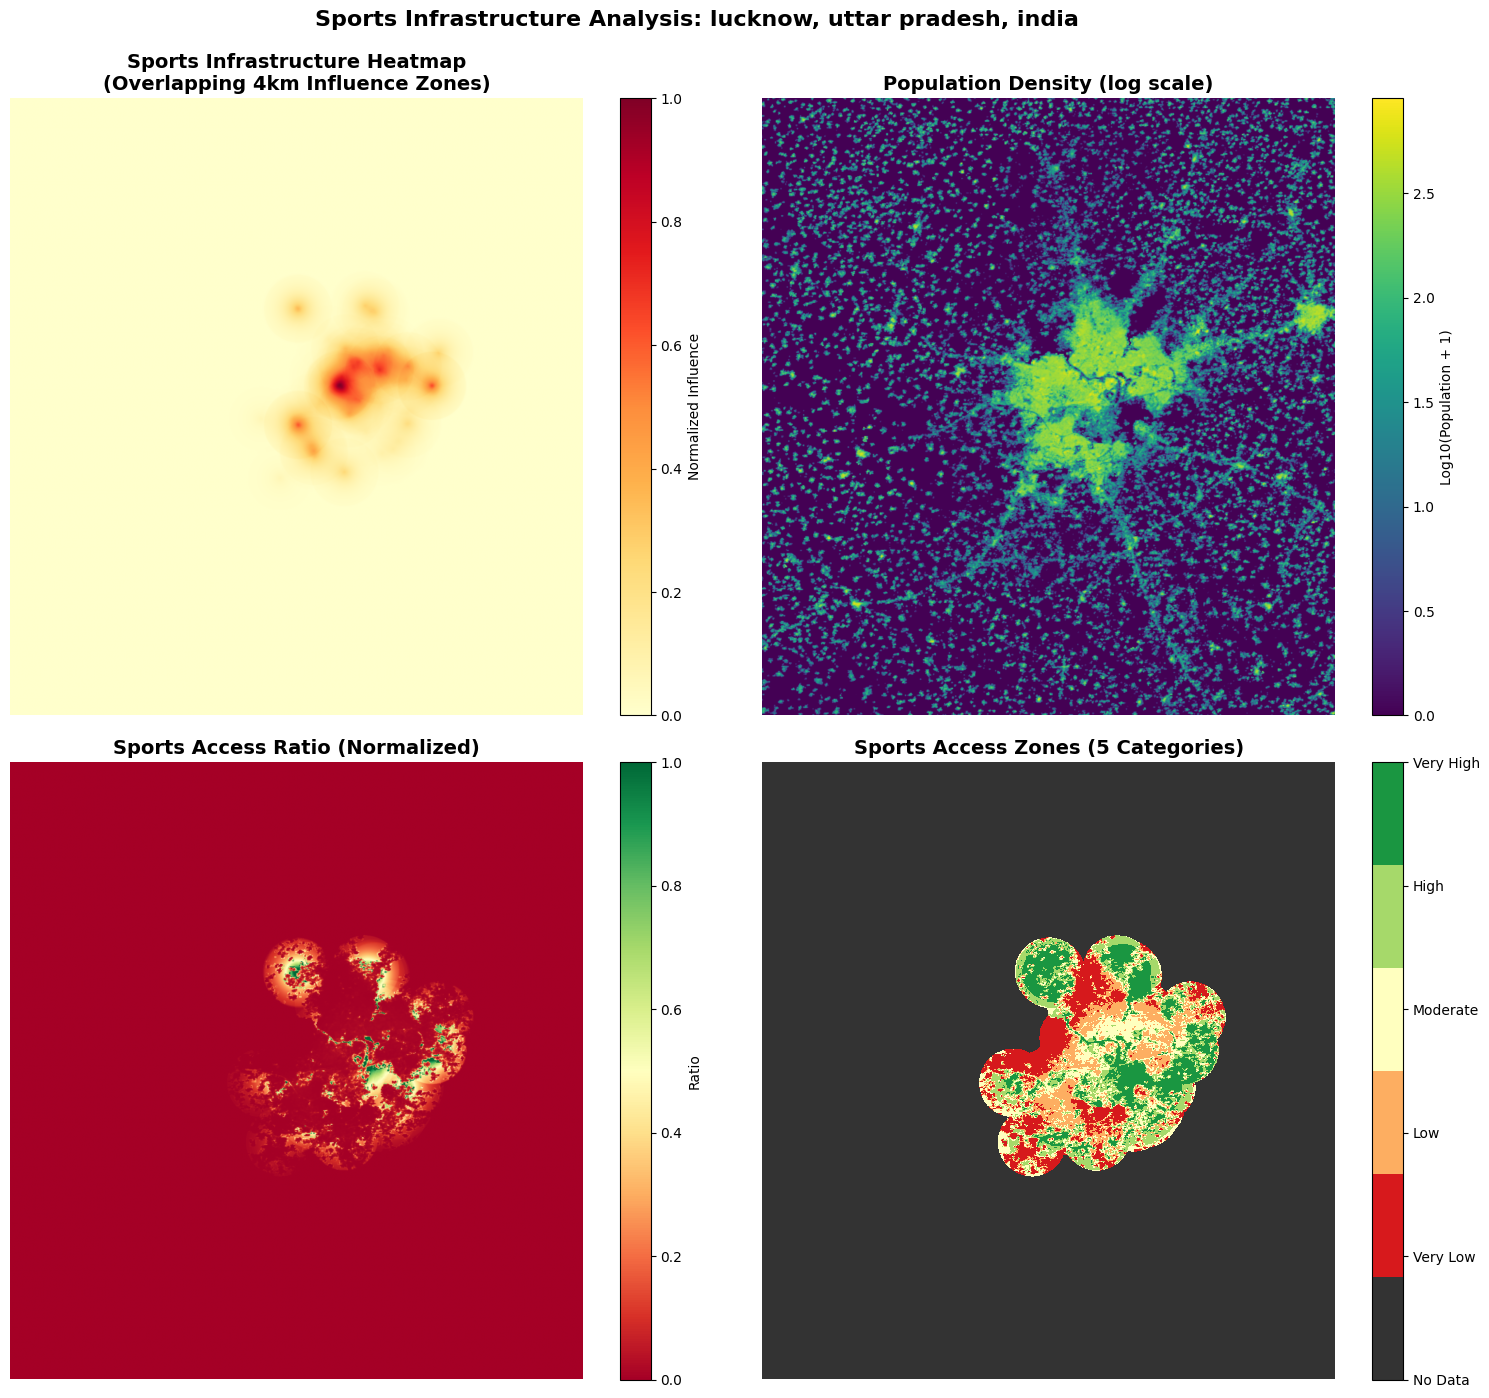


ANALYSIS SUMMARY
Location: lucknow, uttar pradesh, india
Coordinate System: EPSG:32643
Area analyzed: 67.05 km × 72.22 km
Total sports facilities: 135
Total population: 36,560,698
Raster dimensions: 1444 × 1340 pixels
Pixel resolution: 50m

Zone Distribution:
  No Data: 4286.39 km² (777.9%)
  Very Low Sports Access: 110.20 km² (20.0%)
  Low Sports Access: 110.20 km² (20.0%)
  Moderate Sports Access: 110.20 km² (20.0%)
  High Sports Access: 110.20 km² (20.0%)
  Very High Sports Access: 110.20 km² (20.0%)

✓ ANALYSIS COMPLETE!

All files saved in 'gis_output/' directory:
  • boundary.gpkg (vector)
  • sports_infrastructure.gpkg (vector)
  • ghsl_population.tif (raster)
  • sports_access_zones.tif (raster)
  • analysis_visualization.png



In [6]:
# GIS Sports Infrastructure Analysis
# Complete workflow for analyzing sports infrastructure density relative to population

# Installation of required packages
!pip install geopy osmnx geopandas rasterio scipy geemap earthengine-api folium -q

# Import libraries
import os
import ee
import geemap
import osmnx as ox
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from scipy.ndimage import gaussian_filter
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='forest-fire-uttarakhand-465423')

print("All libraries imported successfully!")

# ============================================================================
# STEP 1: INPUT AND VERIFICATION OF LOCATION
# ============================================================================

def verify_location(location_name):
    """
    Verify and geocode location using Nominatim
    """
    geolocator = Nominatim(user_agent="gis_sports_analysis_app")
    try:
        location = geolocator.geocode(location_name, timeout=10)
        if location:
            print(f"✓ Location verified: {location.address}")
            print(f"  Coordinates: ({location.latitude}, {location.longitude})")
            return location_name, location
        else:
            print(f"✗ Location '{location_name}' not found")
            return None, None
    except Exception as e:
        print(f"✗ Error verifying location: {e}")
        return None, None

# Input location
location_input = input("Enter city/state/nation name: ").strip()
if not location_input:
    location_input = "Roorkee, India"  # Default for testing
    print(f"Using default location: {location_input}")

location_string, location_obj = verify_location(location_input)

if not location_string:
    raise ValueError("Invalid location. Please run again with a valid location name.")

# ============================================================================
# STEP 2: DOWNLOAD BOUNDARY AND SPORTS INFRASTRUCTURE USING OSMNX
# ============================================================================

print("\n" + "="*60)
print("Downloading boundary and sports infrastructure...")
print("="*60)

# Download administrative boundary
try:
    boundary_gdf = ox.geocode_to_gdf(location_string)
    print(f"✓ Boundary downloaded: {len(boundary_gdf)} feature(s)")
except Exception as e:
    print(f"✗ Error downloading boundary: {e}")
    raise

# Download sports infrastructure
try:
    tags = {'sport': True}
    sports_gdf = ox.features_from_place(location_string, tags=tags)

    # Filter to get only relevant geometries (points, polygons)
    sports_gdf = sports_gdf[sports_gdf.geometry.type.isin(['Point', 'Polygon', 'MultiPolygon'])]

    print(f"✓ Sports infrastructure downloaded: {len(sports_gdf)} feature(s)")
except Exception as e:
    print(f"Warning: Error downloading sports infrastructure: {e}")
    # Create empty GeoDataFrame if no sports facilities found
    sports_gdf = gpd.GeoDataFrame(geometry=[], crs='EPSG:4326')
    print("  Created empty sports infrastructure dataset")

# ============================================================================
# STEP 3: CONVERT TO MERCATOR PROJECTION (EPSG:32643 - WGS 84 / UTM zone 43N)
# ============================================================================

print("\n" + "="*60)
print("Converting to EPSG:32643 (WGS 84 / UTM zone 43N)...")
print("="*60)

target_crs = 'EPSG:32643'

boundary_gdf = boundary_gdf.to_crs(target_crs)
print(f"✓ Boundary converted to {target_crs}")

if len(sports_gdf) > 0:
    sports_gdf = sports_gdf.to_crs(target_crs)
    print(f"✓ Sports infrastructure converted to {target_crs}")
else:
    sports_gdf = gpd.GeoDataFrame(geometry=[], crs=target_crs)
    print(f"✓ Empty sports infrastructure set to {target_crs}")

# ============================================================================
# STEP 4: RASTERIZE SPORTS INFRASTRUCTURE
# ============================================================================

print("\n" + "="*60)
print("Rasterizing sports infrastructure...")
print("="*60)

# Get bounds from boundary
bounds = boundary_gdf.total_bounds  # minx, miny, maxx, maxy
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]

# Set resolution (50m pixels for better performance with large influence zones)
resolution = 50
cols = int(width / resolution)
rows = int(height / resolution)

# Create transform
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], cols, rows)

# Create coordinate grids for distance calculations
x = np.linspace(bounds[0], bounds[2], cols)
y = np.linspace(bounds[3], bounds[1], rows)  # Note: y is flipped for raster
xx, yy = np.meshgrid(x, y)

# Initialize sports influence raster
sports_raster = np.zeros((rows, cols), dtype=np.float32)

print(f"✓ Raster grid created: {rows}x{cols} pixels at {resolution}m resolution")

# ============================================================================
# STEP 5: CREATE HEATMAP OF SPORTS INFRASTRUCTURE WITH DISTANCE DECAY
# ============================================================================

print("\n" + "="*60)
print("Building sports infrastructure heatmap with influence zones...")
print("="*60)

if len(sports_gdf) > 0:
    # Define influence parameters
    max_influence_distance = 4000  # 4km maximum influence

    print(f"Processing {len(sports_gdf)} sports facilities...")
    print(f"Maximum influence distance: {max_influence_distance/1000}km")

    # Process each sports facility using itertuples for better performance
    facility_count = 0
    for row in sports_gdf.itertuples():
        facility_count += 1

        # Get centroid of facility
        geom = row.geometry
        if geom.geom_type in ['Polygon', 'MultiPolygon']:
            centroid = geom.centroid
        else:
            centroid = geom

        # Calculate distance from this facility to every pixel
        dist = np.sqrt((xx - centroid.x)**2 + (yy - centroid.y)**2)

        # Create distance decay function
        # Maximum value (1.0) at facility location, decays to 0 at max_influence_distance
        # Using inverse distance weighting with exponential decay
        influence = np.zeros_like(dist)
        mask = dist <= max_influence_distance

        # Exponential decay formula: influence = exp(-distance / decay_rate)
        decay_rate = max_influence_distance / 3  # Decay to ~5% at max distance
        influence[mask] = np.exp(-dist[mask] / decay_rate)

        # Add this facility's influence to the cumulative heatmap
        sports_raster += influence

        if facility_count % 50 == 0 or facility_count == len(sports_gdf):
            print(f"  Processed {facility_count}/{len(sports_gdf)} facilities...")

    print(f"✓ Heatmap created with overlapping {max_influence_distance/1000}km influence zones")
    print(f"  Heatmap range: {sports_raster.min():.3f} to {sports_raster.max():.3f}")
    print(f"  Maximum overlaps: {sports_raster.max():.1f} facilities")

    # Store the raw heatmap for ratio calculation
    sports_heatmap = sports_raster.copy()

    # Create normalized version for visualization
    if sports_heatmap.max() > 0:
        sports_heatmap_viz = sports_heatmap / sports_heatmap.max()
    else:
        sports_heatmap_viz = sports_heatmap
else:
    print("✓ No sports facilities found, creating empty heatmap")
    sports_raster = np.zeros((rows, cols), dtype=np.float32)
    sports_heatmap = sports_raster.copy()
    sports_heatmap_viz = sports_raster.copy()

# ============================================================================
# STEP 6: IMPORT GHSL POPULATION DATA USING GEEMAP
# ============================================================================

print("\n" + "="*60)
print("Importing GHSL population data...")
print("="*60)

# Get boundary in lat/lon for Earth Engine
boundary_latlon = boundary_gdf.to_crs('EPSG:4326')
bounds_latlon = boundary_latlon.total_bounds

# Create Earth Engine geometry
ee_geometry = ee.Geometry.Rectangle([
    bounds_latlon[0], bounds_latlon[1],
    bounds_latlon[2], bounds_latlon[3]
])

# Load GHSL population data
ghsl = ee.ImageCollection("JRC/GHSL/P2023A/GHS_POP").filterBounds(ee_geometry)

# Get the most recent year (2025)
pop_image = ghsl.select('population_count').mosaic().clip(ee_geometry)

print("✓ GHSL population data loaded")

# Download population raster
pop_array = geemap.ee_to_numpy(
    pop_image,
    region=ee_geometry,
    scale=100,  # 100m resolution
    bands=['population_count']
)

# Handle potential issues with downloaded data
if pop_array.ndim == 3:
    pop_array = pop_array[:, :, 0]

print(f"✓ Population data downloaded: {pop_array.shape}")

# Resample population to match sports raster resolution
from scipy.ndimage import zoom
zoom_factor_y = rows / pop_array.shape[0]
zoom_factor_x = cols / pop_array.shape[1]
pop_resampled = zoom(pop_array, (zoom_factor_y, zoom_factor_x), order=1)

print(f"✓ Population resampled to match sports raster: {pop_resampled.shape}")

# ============================================================================
# STEP 7: CREATE ZONING MAP (SPORTS INFRA / POPULATION RATIO)
# ============================================================================

print("\n" + "="*60)
print("Creating zoning map based on sports/population ratio...")
print("="*60)

# Calculate ratio with safeguards
# Use the raw heatmap values (not normalized) for meaningful ratio
pop_safe = np.where(pop_resampled > 0, pop_resampled, 1)  # Avoid division by zero
ratio = sports_heatmap / (pop_safe + 1)  # Add 1 to avoid extreme values

# Normalize ratio to 0-1
if ratio.max() > 0:
    ratio_normalized = ratio / np.percentile(ratio[ratio > 0], 99)  # Use 99th percentile
    ratio_normalized = np.clip(ratio_normalized, 0, 1)
else:
    ratio_normalized = ratio

# Create 5 zones based on quantiles
zones = np.zeros_like(ratio_normalized, dtype=np.uint8)
if ratio_normalized.max() > 0:
    quantiles = np.percentile(ratio_normalized[ratio_normalized > 0], [20, 40, 60, 80])
    zones[ratio_normalized > 0] = 1
    zones[ratio_normalized > quantiles[0]] = 2
    zones[ratio_normalized > quantiles[1]] = 3
    zones[ratio_normalized > quantiles[2]] = 4
    zones[ratio_normalized > quantiles[3]] = 5

zone_labels = {
    0: "No Data",
    1: "Very Low Sports Access",
    2: "Low Sports Access",
    3: "Moderate Sports Access",
    4: "High Sports Access",
    5: "Very High Sports Access"
}

print("✓ Zoning map created with 5 zones")
for zone, label in zone_labels.items():
    count = np.sum(zones == zone)
    pct = (count / (zones.size - np.sum(zones == 0))) * 100
    print(f"  Zone {zone} ({label}): {count} pixels ({pct:.1f}%)")

# ============================================================================
# STEP 8: SAVE ALL OUTPUT FILES
# ============================================================================

print("\n" + "="*60)
print("Saving output files...")
print("="*60)

# Create output directory
os.makedirs('gis_output', exist_ok=True)

# 1. Save boundary vector
boundary_file = 'gis_output/boundary.gpkg'
boundary_gdf.to_file(boundary_file, driver='GPKG')
print(f"✓ Saved: {boundary_file}")

# 2. Save sports infrastructure vector
sports_file = 'gis_output/sports_infrastructure.gpkg'
if len(sports_gdf) > 0:
    sports_gdf.to_file(sports_file, driver='GPKG')
else:
    # Save empty geodataframe
    empty_gdf = gpd.GeoDataFrame(geometry=[], crs=target_crs)
    empty_gdf.to_file(sports_file, driver='GPKG')
print(f"✓ Saved: {sports_file}")

# 3. Save GHSL population raster
pop_file = 'gis_output/ghsl_population.tif'
with rasterio.open(
    pop_file, 'w',
    driver='GTiff',
    height=pop_resampled.shape[0],
    width=pop_resampled.shape[1],
    count=1,
    dtype=pop_resampled.dtype,
    crs=target_crs,
    transform=transform,
    compress='lzw'
) as dst:
    dst.write(pop_resampled, 1)
print(f"✓ Saved: {pop_file}")

# 4. Save resultant zoning map raster
zones_file = 'gis_output/sports_access_zones.tif'
with rasterio.open(
    zones_file, 'w',
    driver='GTiff',
    height=zones.shape[0],
    width=zones.shape[1],
    count=1,
    dtype=zones.dtype,
    crs=target_crs,
    transform=transform,
    compress='lzw'
) as dst:
    dst.write(zones, 1)
print(f"✓ Saved: {zones_file}")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n" + "="*60)
print("Creating visualizations...")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Sports Infrastructure Heatmap
ax1 = axes[0, 0]
im1 = ax1.imshow(sports_heatmap_viz, cmap='YlOrRd', interpolation='bilinear')
ax1.set_title('Sports Infrastructure Heatmap\n(Overlapping 4km Influence Zones)', fontsize=14, fontweight='bold')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, label='Normalized Influence', fraction=0.046)

# 2. Population Density
ax2 = axes[0, 1]
pop_display = np.log10(pop_resampled + 1)  # Log scale for better visualization
im2 = ax2.imshow(pop_display, cmap='viridis', interpolation='bilinear')
ax2.set_title('Population Density (log scale)', fontsize=14, fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, label='Log10(Population + 1)', fraction=0.046)

# 3. Sports/Population Ratio
ax3 = axes[1, 0]
im3 = ax3.imshow(ratio_normalized, cmap='RdYlGn', interpolation='bilinear', vmin=0, vmax=1)
ax3.set_title('Sports Access Ratio (Normalized)', fontsize=14, fontweight='bold')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, label='Ratio', fraction=0.046)

# 4. Final Zoning Map
ax4 = axes[1, 1]
cmap_zones = LinearSegmentedColormap.from_list('zones',
    ['#333333', '#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641'], N=6)
im4 = ax4.imshow(zones, cmap=cmap_zones, interpolation='nearest', vmin=0, vmax=5)
ax4.set_title('Sports Access Zones (5 Categories)', fontsize=14, fontweight='bold')
ax4.axis('off')
cbar4 = plt.colorbar(im4, ax=ax4, ticks=[0, 1, 2, 3, 4, 5], fraction=0.046)
cbar4.set_ticklabels(['No Data', 'Very Low', 'Low', 'Moderate', 'High', 'Very High'])

plt.suptitle(f'Sports Infrastructure Analysis: {location_string}',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('gis_output/analysis_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Saved: gis_output/analysis_visualization.png")
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Location: {location_string}")
print(f"Coordinate System: {target_crs}")
print(f"Area analyzed: {(width/1000):.2f} km × {(height/1000):.2f} km")
print(f"Total sports facilities: {len(sports_gdf)}")
print(f"Total population: {int(pop_resampled.sum()):,}")
print(f"Raster dimensions: {rows} × {cols} pixels")
print(f"Pixel resolution: {resolution}m")
print(f"\nZone Distribution:")
for zone, label in zone_labels.items():
    count = np.sum(zones == zone)
    pct = (count / (zones.size - np.sum(zones == 0))) * 100
    area_km2 = (count * resolution * resolution) / 1_000_000
    print(f"  {label}: {area_km2:.2f} km² ({pct:.1f}%)")

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE!")
print("="*60)
print("\nAll files saved in 'gis_output/' directory:")
print("  • boundary.gpkg (vector)")
print("  • sports_infrastructure.gpkg (vector)")
print("  • ghsl_population.tif (raster)")
print("  • sports_access_zones.tif (raster)")
print("  • analysis_visualization.png")
print("\n" + "="*60)

# ChatGPTv5.2 GO

In [ ]:
import os, sys, subprocess, time
subprocess.check_call([sys.executable, "-m", "pip", "install",
                       "osmnx", "geopandas", "geopy", "rasterio",
                       "shapely", "pyproj", "geemap",
                       "earthengine-api", "rioxarray", "scipy"])

import numpy as np
import geopandas as gpd
import osmnx as ox
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderUnavailable, GeocoderTimedOut
import rasterio
from rasterio import features
from rasterio.transform import from_bounds
from scipy.ndimage import gaussian_filter
import rioxarray as rxr
import xarray as xr
import geemap
import ee

# ------------------ EARTH ENGINE INIT ------------------
ee.Authenticate()
ee.Initialize(project='')

# ------------------ USER INPUT + GEOCODING ------------------
place_name = input("Enter city / state / country: ")
geolocator = Nominatim(user_agent="gis_llm_benchmark", timeout=10)

location = None
for _ in range(5):
    try:
        location = geolocator.geocode(place_name)
        if location:
            break
    except (GeocoderUnavailable, GeocoderTimedOut):
        time.sleep(2)

if location is None:
    raise RuntimeError("Nominatim failed after retries")

verified_place = location.address
print("Verified location:", verified_place)

# ------------------ OSM DATA ------------------
ox.settings.use_cache = True
ox.settings.log_console = False

boundary_gdf = ox.geocode_to_gdf(verified_place)
sports_gdf = ox.features_from_place(verified_place, tags={"sport": True})
sports_gdf = sports_gdf[sports_gdf.geometry.notnull()]

# ------------------ CRS ------------------
TARGET_CRS = "EPSG:32643"
boundary_gdf = boundary_gdf.to_crs(TARGET_CRS)
sports_gdf = sports_gdf.to_crs(TARGET_CRS)

# ------------------ OUTPUT DIR ------------------
os.makedirs("outputs", exist_ok=True)

boundary_fp = "outputs/boundary.gpkg"
sports_fp = "outputs/sports_infra.gpkg"
boundary_gdf.to_file(boundary_fp, driver="GPKG")
sports_gdf.to_file(sports_fp, driver="GPKG")

# ------------------ RASTERIZE SPORTS ------------------
minx, miny, maxx, maxy = boundary_gdf.total_bounds
res = 100
width = int((maxx - minx) / res)
height = int((maxy - miny) / res)
transform = from_bounds(minx, miny, maxx, maxy, width, height)

sports_raster = features.rasterize(
    ((geom, 1) for geom in sports_gdf.geometry),
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)

sports_raster_fp = "outputs/sports_raster.tif"
with rasterio.open(
    sports_raster_fp, "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="uint8",
    crs=TARGET_CRS,
    transform=transform
) as dst:
    dst.write(sports_raster, 1)

# ------------------ HEATMAP ------------------
heatmap = gaussian_filter(sports_raster.astype(float), sigma=5)
heatmap_fp = "outputs/sports_heatmap.tif"
with rasterio.open(
    heatmap_fp, "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs=TARGET_CRS,
    transform=transform
) as dst:
    dst.write(heatmap.astype("float32"), 1)

# ------------------ GHSL POPULATION ------------------
boundary_ee = geemap.geopandas_to_ee(boundary_gdf)
ghsl_ic = ee.ImageCollection("JRC/GHSL/P2023A/GHS_POP")
ghsl_img = ghsl_ic.mosaic().clip(boundary_ee)

ghsl_fp = "outputs/ghsl_population.tif"
geemap.ee_export_image(
    ghsl_img,
    filename=ghsl_fp,
    scale=100,
    region=boundary_ee.geometry(),
    file_per_band=False
)

# ------------------ ZONING (NaN-SAFE) ------------------
sports_xr = rxr.open_rasterio(sports_raster_fp, masked=True)
pop_xr = rxr.open_rasterio(ghsl_fp, masked=True)
pop_xr = pop_xr.rio.reproject_match(sports_xr)

ratio = sports_xr / (pop_xr + 1)

valid = ratio.values[~np.isnan(ratio.values)]
bins = np.quantile(valid, [0.2, 0.4, 0.6, 0.8])

zones = xr.apply_ufunc(np.digitize, ratio, bins)
zones = zones.where(~np.isnan(ratio), 0).astype("uint8")

zones_fp = "outputs/sports_population_zones.tif"
zones = zones.rio.write_crs(TARGET_CRS)
zones = zones.rio.write_nodata(0, inplace=True)
zones.rio.to_raster(zones_fp)

# ------------------ FINAL OUTPUTS ------------------
print("Generated outputs:")
print(boundary_fp)
print(sports_fp)
print(sports_raster_fp)
print(heatmap_fp)
print(ghsl_fp)
print(zones_fp)


Enter city / state / country: lucknow, uttar pradesh, india
Verified location: Lucknow, Uttar Pradesh, 226027, India
Generating URL ...
Please wait ...
Data downloaded to /content/outputs/ghsl_population.tif
Generated outputs:
outputs/boundary.gpkg
outputs/sports_infra.gpkg
outputs/sports_raster.tif
outputs/sports_heatmap.tif
outputs/ghsl_population.tif
outputs/sports_population_zones.tif


# GEMINIv3

In [1]:
# @title GIS Development Pipeline: Sports Infrastructure Zoning
# @markdown Run this cell to execute the full workflow.

import os
import sys

# ---------------------------------------------------------
# 1. INSTALLATION & SETUP
# ---------------------------------------------------------
print("Installing required libraries... (This may take a minute)")
!pip install -q osmnx geemap rasterio geopandas geopy scipy

import geopy
from geopy.geocoders import Nominatim
import osmnx as ox
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.transform import from_bounds
import numpy as np
import scipy.ndimage
import geemap
import ee
import matplotlib.pyplot as plt
from google.colab import files

# Authenticate Earth Engine (User interaction required here)
ee.Authenticate()
ee.Initialize(project='forest-fire-uttarakhand-465423')

# ---------------------------------------------------------
# 2. INPUT & VERIFICATION
# ---------------------------------------------------------
loc_input = input("Enter City/State/Nation (e.g., 'Chandigarh, India'): ")
geolocator = Nominatim(user_agent="gis_linkedin_test")

try:
    location = geolocator.geocode(loc_input)
    if location:
        place_name = location.address.split(",")[0]
        full_place_name = location.address
        print(f"Verified Location: {full_place_name}")
    else:
        raise ValueError("Location not found.")
except Exception as e:
    sys.exit(f"Error validating location: {e}")

# ---------------------------------------------------------
# 3. DOWNLOAD VECTOR DATA (OSMNX)
# ---------------------------------------------------------
print(f"Downloading vector data for: {place_name}...")

# 3a. Boundary
try:
    gdf_boundary = ox.geocode_to_gdf(loc_input)
except Exception as e:
    sys.exit(f"OSMnx Boundary Error: {e}")

# 3b. Sports Infrastructure
try:
    # "sport": True fetches all objects with a 'sport' tag
    gdf_sports = ox.features_from_place(loc_input, tags={"sport": True})
    if gdf_sports.empty:
        print("No sports infrastructure found. Generating dummy data for demonstration.")
        # Create a dummy point in the center if no data exists to prevent crash
        gdf_sports = gpd.GeoDataFrame(
            geometry=[gdf_boundary.centroid.iloc[0]], crs=gdf_boundary.crs
        )
        gdf_sports["sport"] = "dummy"
except Exception as e:
    print(f"OSMnx Sports Data Error: {e}. Using centroid as fallback.")
    gdf_sports = gpd.GeoDataFrame(
        geometry=[gdf_boundary.centroid.iloc[0]], crs=gdf_boundary.crs
    )

# ---------------------------------------------------------
# 4. REPROJECTION (EPSG:32643)
# ---------------------------------------------------------
# Note: EPSG:32643 is UTM Zone 43N (India).
# Using this for locations far outside this zone (e.g., USA) will cause distortion,
# but strictly following user prompt instructions.
target_crs = "EPSG:32643"
print(f"Reprojecting to {target_crs}...")

gdf_boundary = gdf_boundary.to_crs(target_crs)
gdf_sports = gdf_sports.to_crs(target_crs)

# Save Vectors
gdf_boundary.to_file("boundary.gpkg", driver="GPKG")
gdf_sports.to_file("sports_infra.gpkg", driver="GPKG")

# ---------------------------------------------------------
# 5. RASTERIZATION & HEATMAP
# ---------------------------------------------------------
print("Rasterizing and generating heatmap...")

# Define raster grid based on boundary bounds
minx, miny, maxx, maxy = gdf_boundary.total_bounds
pixel_size = 100  # 100m resolution
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Rasterize Sports Vector (Burn value=1)
# We use 'all_touched=True' to ensure points/lines are caught
shapes = ((geom, 1) for geom in gdf_sports.geometry)
sports_raster = features.rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.float32
)

# Apply Gaussian Filter for Heatmap (Spread Extent)
# Sigma=5 pixels (approx 500m spread)
heatmap = scipy.ndimage.gaussian_filter(sports_raster, sigma=5)

# Normalize Heatmap (0 to 1)
if np.max(heatmap) > 0:
    heatmap_norm = heatmap / np.max(heatmap)
else:
    heatmap_norm = heatmap

# ---------------------------------------------------------
# 6. IMPORT GHSL POPULATION (GEEMAP)
# ---------------------------------------------------------
print("Fetching GHSL Population data...")

# Region of Interest from Boundary
# We must reproject boundary back to EPSG:4326 for Earth Engine
roi_gdf = gdf_boundary.to_crs("EPSG:4326")
# Simplify geometry slightly to avoid EE payload limits if complex
roi_geom = geemap.gdf_to_ee(roi_gdf)

# Load GHSL P2023A Collection and select year 2025 (Projected)
# Band is 'population_count'
ghsl_col = ee.ImageCollection("JRC/GHSL/P2023A/GHS_POP")
pop_image = ghsl_col.filter(ee.Filter.calendarRange(2025, 2025, 'year')).first()

# Download GHSL as GeoTIFF to match our local raster grid
# We export it matching the crs, scale, and region of our local analysis
out_pop_file = "ghsl_pop_2025.tif"
geemap.ee_export_image(
    pop_image,
    filename=out_pop_file,
    scale=pixel_size,
    crs=target_crs,
    region=roi_geom.geometry(),
    file_per_band=False
)

# ---------------------------------------------------------
# 7. ZONING ANALYSIS (Sports/Pop Ratio)
# ---------------------------------------------------------
print("Calculating Zones...")

# Read the downloaded Population Raster
with rasterio.open(out_pop_file) as src:
    pop_data = src.read(1)
    # Ensure shapes match (resampling if slightly off due to export quirks)
    if pop_data.shape != heatmap_norm.shape:
        # Simple crop/pad or resize if 1-pixel off (common in raster IO)
        # For robustness, we re-read pop into the exact shape of sports raster
        pop_data = src.read(1, out_shape=(height, width), resampling=rasterio.enums.Resampling.bilinear)

# Handle NoData and Zeros
pop_data = np.nan_to_num(pop_data, nan=0.0)
pop_data[pop_data < 0] = 0 # GHSL NoData is often negative

# Calculate Ratio: (Sports Access / Population Density)
# Add small epsilon to pop to avoid division by zero
epsilon = 1e-5
ratio_map = heatmap_norm / (pop_data + epsilon)

# Zone into 5 classes (Quantiles)
# We only classify areas inside the boundary (masking)
# Rasterize boundary for masking
boundary_mask = features.rasterize(
    shapes=[(geom, 1) for geom in gdf_boundary.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
)

valid_pixels = ratio_map[boundary_mask == 1]

if len(valid_pixels) > 0:
    # Calculate quantiles ignoring outliers
    quantiles = np.percentile(valid_pixels, [20, 40, 60, 80])
    zones = np.zeros_like(ratio_map, dtype=np.uint8)

    # Assign Zones 1-5
    zones[ratio_map <= quantiles[0]] = 1
    zones[(ratio_map > quantiles[0]) & (ratio_map <= quantiles[1])] = 2
    zones[(ratio_map > quantiles[1]) & (ratio_map <= quantiles[2])] = 3
    zones[(ratio_map > quantiles[2]) & (ratio_map <= quantiles[3])] = 4
    zones[ratio_map > quantiles[3]] = 5

    # Mask outside boundary
    zones = zones * boundary_mask
else:
    zones = np.zeros_like(ratio_map, dtype=np.uint8)

# Save Final Raster
meta = {
    'driver': 'GTiff',
    'height': height,
    'width': width,
    'count': 1,
    'dtype': 'uint8',
    'crs': target_crs,
    'transform': transform
}

with rasterio.open('final_zoning_map.tif', 'w', **meta) as dst:
    dst.write(zones, 1)

# ---------------------------------------------------------
# 8. DOWNLOAD FILES
# ---------------------------------------------------------
print("Downloading files...")
files.download("boundary.gpkg")
files.download("sports_infra.gpkg")
files.download("ghsl_pop_2025.tif")
files.download("final_zoning_map.tif")

print("Process Complete. Zones: 1 (Low Infra/High Pop) -> 5 (High Infra/Low Pop)")

Installing required libraries... (This may take a minute)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.7 MB/s eta 0:00:00
Enter City/State/Nation (e.g., 'Chandigarh, India'): lucknow, uttar pradesh, india
Verified Location: Lucknow, Uttar Pradesh, 226027, India
Reprojecting to EPSG:32643...
Rasterizing and generating heatmap...
Fetching GHSL Population data...
Generating URL ...
Please wait ...
Data downloaded to /content/ghsl_pop_2025.tif
Calculating Zones...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Process Complete. Zones: 1 (Low Infra/High Pop) -> 5 (High Infra/Low Pop)
